# 4 OAD updates

In this project,
we seek to optimize an aircraft of approximately 150 passengers that flies at Mach 0.78,
using different engine and fuel technologies.

## The OAD problem

The OAD problem is to find the values of the design parameters 
that minimize the maximum take-off mass (MTOM, `mtom` in the code) under some operation constraints.
Note that the MTOM of an airplane is a good criterion to optimize the design.
Alternative objectives are the cash operating cost (COC, `coc` in the code) or the direct operating cost (DOC, `doc` in the code).

### The design parameters

The **design parameters** are :

- the maximum sea level static thrust  (100 kN ≤ slst ≤ 200 kN, default: 150 kN),
- the number of passengers  (120 ≤ n_pax ≤ 180, default: 150),
- the wing area (100 m² ≤ area ≤ 200 m², default: 180 m²),
- the wing aspect ratio  (5 ≤ ar ≤ 20, default: 9.).

### The operational constraints

The **operational constraints** are :

- the take-off field length (tofl ≤ 1900 m),
- the approach speed (vapp ≤ 135 kt),
- the vertical speed (300 ft/min ≤ vz),
- the wing span (span ≤ 40 m),
- the wing length (length ≤ 45 m),
- the fuel margin (0% ≤ fm).

## The uncertain parameters

In Problems 2 and 3,
some parameters are considered as uncertain.

These uncertain parameters are modelled as random variables defined by probability distributions:

| Variable | Distribution          | Fuel type | Engine type |
|----------|-----------------------|-----------|-------------|
| `gi`     | T(0.35, 0.4, 0.405)   | liquid_h2 | All         |
| `vi`     | T(0.755, 0.800, 0805) | liquid_h2 | All         |
| `aef`    | T(0.99, 1., 1.03)     | All       | All         |
| `cef`    | T(0.99, 1., 1.03)     | All       | All         |
| `aef`    | T(0.99, 1., 1.03)     | All       | All         |
| `fc_pwd` | T(0.8, 1, 1.02)       | liquid_h2 | electrofan  |
| `bed`    | U(400,700)            | battery   | All         |

where `T(minimum, mode, maximum)` and `U(minimum,maximum)`
represent the [triangular distribution](https://en.wikipedia.org/wiki/Triangular_distribution)
and the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution) respectively.
the last two columns indicate the type of fuel and the type of engine
for which these uncertain parameters are relevant.

The parameters `aef`, `cef` and `aef` are related
to the three main technical areas involved in aircraft design,
namely aerodynamics, propulsion and structure.
The lower, the better.
These factors are representing the unknown
included in any creative activity.
Their probability distributions are not symmetrical
as it is always easier to make something less efficient than expected...

## The 12 models

The 12 models are defined in `gemseo-oad` as Python functions:



In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [2]:
from gemseo import configure_logger

configure_logger()

<RootLogger root (INFO)>

## Problème 1 - Modélisation par surrogate et optimisation

Nous allons créer un modèle de substitution (surrogate model) noté :

$$
\hat{f} : x \mapsto \hat{f}(x) = f(x, u_{\mathrm{default}})
$$

Ce modèle approxime la fonction objectif ainsi que les contraintes du problème de conception, en fonction des paramètres de conception \(x\), avec les conditions d'utilisation fixées à $u_{\mathrm{default}}$.

Une fois ce modèle construit, nous l'utiliserons dans un processus d'optimisation pour :

- **Minimiser** la fonction objectif,
- **Respecter** les contraintes imposées,

en faisant varier les paramètres de conception \(x\).



## The units

The use cases are written using common units.

The models only know STANDARD UNITS which means
that all data provided to the function MUST be expressed in standard units
and that all data retrieved by the function are expressed in standard units.

!!! tip "Convert units"
    The functions `convert_from` and `convert_to` from `gemseo_oad_training.unit` can make the conversion easier.

## The four use cases

| Id  | Fuel type | Engine type | Design range (km) |
|-----|-----------|-------------|-------------------|
| UC1 | Kerosene  | Turbofan    | 5500              |
| UC2 | Hydrogen  | Turbofan    | 5500              |
| UC3 | Hydrogen  | Electrofan  | 5500              |
| UC4 | Battery   | Electrofan  | 500               |

In [3]:
# On veut résoudre le problème 1 avec UC1 et UC2
from gemseo.disciplines.auto_py import AutoPyDiscipline

disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# from lh2pac.utils import update_default_inputs
# update_default_inputs(disciplines, {})


In [4]:

# from gemseo import generate_coupling_graph
# generate_coupling_graph(disciplines=disciplines, file_path='')

In [5]:
# generate_coupling_graph(disciplines=disciplines, file_path='', full=False)

In [6]:
# # Generate n2 plot

# from gemseo import generate_n2_plot
# generate_n2_plot(disciplines=disciplines, file_path='')

### create uncertain space

In [7]:
from gemseo.algos.parameter_space import ParameterSpace

uncertain_space = ParameterSpace()

In [8]:
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

In [9]:
# from gemseo_oad_training.unit import convert_from

# uncertain_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
# uncertain_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
# uncertain_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
# uncertain_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [10]:
# uncertain_space

### propagate uncertainties

In [11]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [12]:
dataset = sample_disciplines(disciplines, uncertain_space, ["mtom"], algo_name="OT_MONTE_CARLO", n_samples=1000)


    INFO - 17:19:11: *** Start Sampling execution ***
    INFO - 17:19:11: Sampling
    INFO - 17:19:11:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:19:11:    MDO formulation: MDF
    INFO - 17:19:11: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:19:14:     19%|█▉        | 191/1000 [00:02<00:11, 68.29 it/sec]Traceback (most recent call last):
Exception in thread subprocess:
Traceback (most recent call last):
  File "/home/sara/Documents/5 ModIA/S2/metamodelisation/lh2pac_project/lh2pac/.venv/lib/python3.11/site-packages/ipykernel/iostream.py", line 142, in _event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sara/Documents/5 ModIA/S2/metamodelisation/lh2pac_project/lh2pac/.venv/lib/python3.11/site-packages/gemseo/core/parallel_execution/call

In [13]:
statistics = EmpiricalStatistics(dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.0081097]),
 'cef': array([1.00619227]),
 'mtom': array([70422.03916757]),
 'sef': array([1.00773897])}

In [14]:
variance = statistics.compute_variance()
variance

{'aef': array([7.54583052e-05]),
 'cef': array([8.00808646e-05]),
 'mtom': array([83703.04657027]),
 'sef': array([6.87168823e-05])}

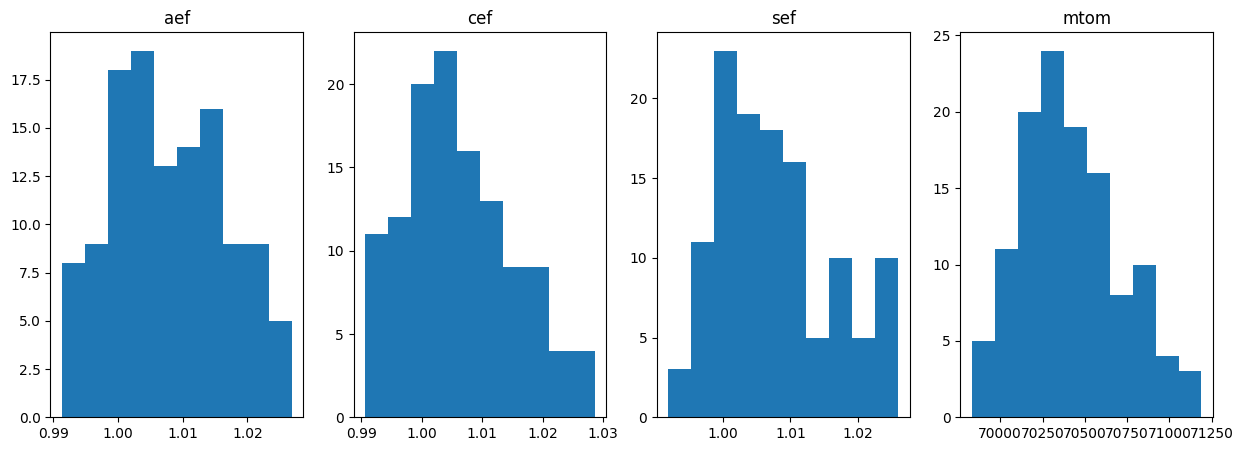

In [15]:
fig, axes = plt.subplots(1, 4, figsize = (15,5))
for ax, name in zip(axes, ["aef", "cef", "sef", "mtom"]):
    ax.hist(dataset.get_view(variable_names=name))
    ax.set_title(name)

### analyse de sensibilité

In [16]:
import pprint

from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from numpy import pi

In [32]:
samples = sobol.samples  # Input samples
outputs = sobol.outputs  # Corresponding outputs

print(outputs)
print("Output variµance:", np.var(outputs))

AttributeError: 'SobolAnalysis' object has no attribute 'samples'

In [33]:
sobol = SobolAnalysis()
sobol.compute_samples(disciplines, uncertain_space, 100)
# sobol.compute_indices()

    INFO - 17:18:22: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:18:22: SobolAnalysisSamplingPhase
    INFO - 17:18:22:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:18:22:    MDO formulation: MDF
    INFO - 17:18:22: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:18:24:     14%|█▍        | 145/1000 [00:01<00:11, 73.93 it/sec]Traceback (most recent call last):
Exception in thread subprocess:
Traceback (most recent call last):
  File "/home/sara/Documents/5 ModIA/S2/metamodelisation/lh2pac_project/lh2pac/.venv/lib/python3.11/site-packages/ipykernel/iostream.py", line 142, in _event_pipe
    event_pipe = self._local.event_pipe
                 ^^^^^^^^^^^^^^^^^^^^^^
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sara/Documents/5 

: 

ulimit -n

In [ ]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

In [6]:
# Create the design space
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from

design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [7]:
# Add the constraints
from gemseo.scenarios.mdo_scenario import MDOScenario
scenario = MDOScenario(disciplines=disciplines, design_space=design_space, objective_name= "mtom",formulation_name='MDF')
scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False)
scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False)
scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True)
scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False)
scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False)
scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True)

In [8]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 16:27:08: *** Start MDOScenario execution ***
    INFO - 16:27:08: MDOScenario
    INFO - 16:27:08:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 16:27:08:    MDO formulation: MDF
    INFO - 16:27:08: Optimization problem:
    INFO - 16:27:08:    minimize mtom(slst, n_pax, area, ar)
    INFO - 16:27:08:    with respect to ar, area, n_pax, slst
    INFO - 16:27:08:    subject to constraints:
    INFO - 16:27:08:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 16:27:08:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 16:27:08:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 16:27:08:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 16:27:08:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 16:27:08:       fm(slst, n_pax, area, ar) >= 0.0
    INFO - 16:27:08:    over the design space:
    INFO - 16:27:08:       +-------+-------------+--------+--------

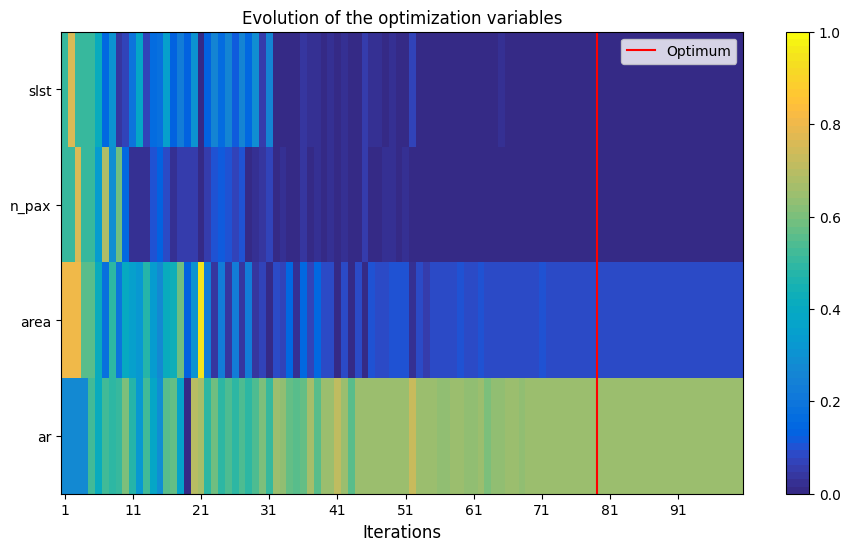

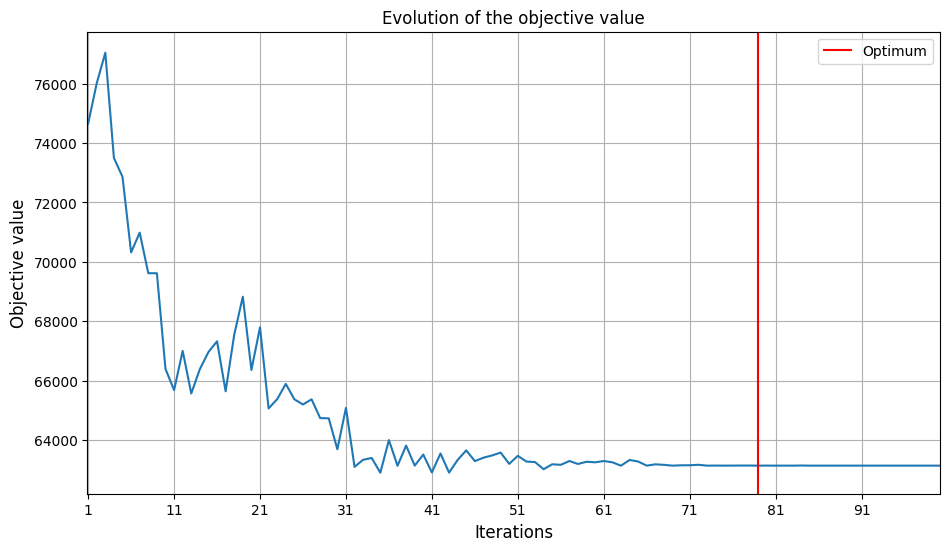

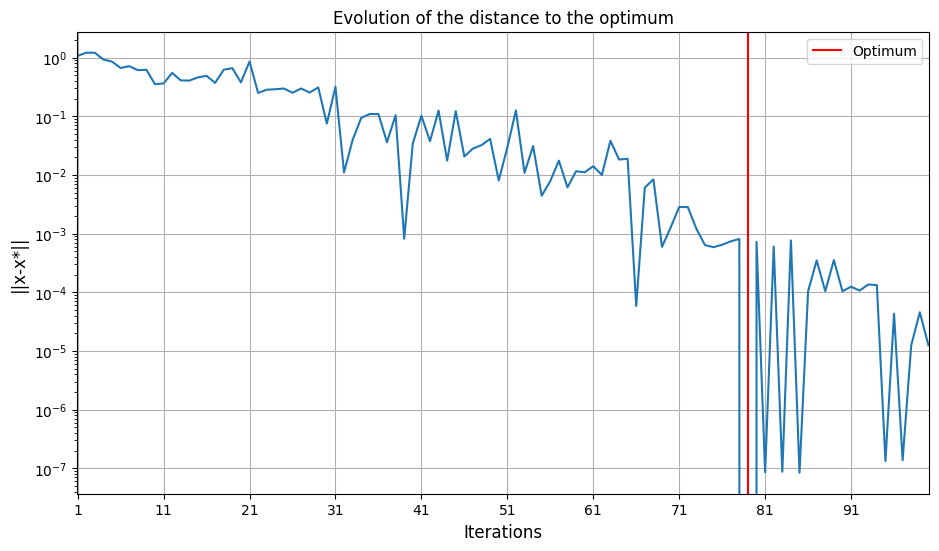

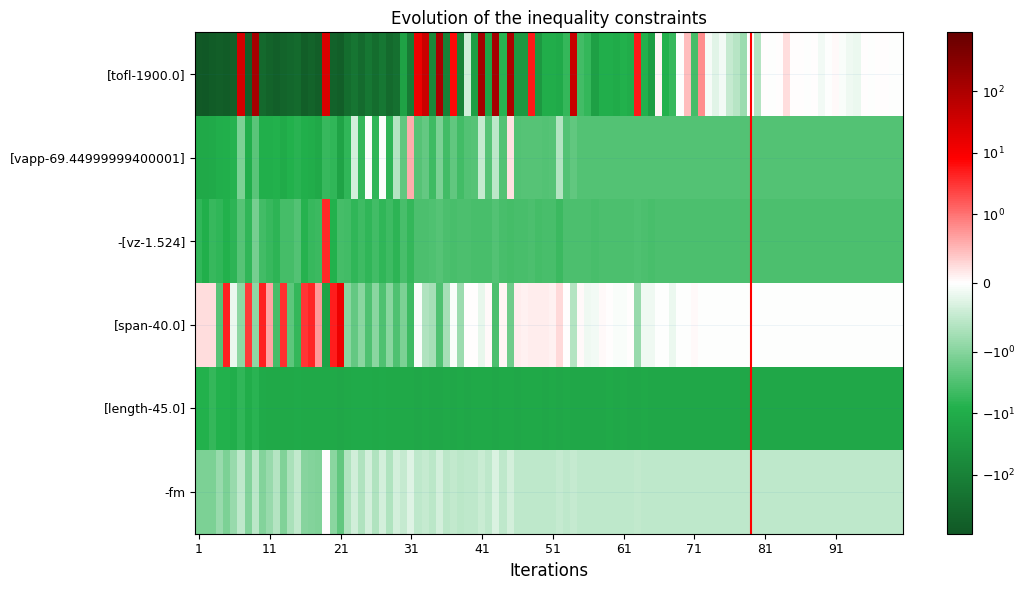

In [9]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

## Import surrogate

In [13]:
from gemseo import from_pickle
from gemseo import import_discipline

surrogate_discipline = import_discipline("my_surrogate.pkl")


In [18]:
from gemseo import create_scenario

scenario_surr = create_scenario(surrogate_discipline, design_space=design_space, objective_name= "mtom",formulation_name='MDF')
scenario_surr.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False)
scenario_surr.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False)
scenario_surr.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True)
scenario_surr.add_constraint('span', constraint_type='ineq', value=40.0, positive=False)
scenario_surr.add_constraint('length', constraint_type='ineq', value=45.0, positive=False)
scenario_surr.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True)

 WARNING - 16:33:14: No coupling in MDA, switching chain_linearize to True.


In [23]:
surrogate_discipline

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 20
   Surrogate model: RBFRegressor
   Inputs: ar, area, n_pax, slst
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

In [24]:
# # Add the constraints
# from gemseo.scenarios.mdo_scenario import MDOScenario
# scenario = MDOScenario(disciplines=surrogate_discipline, design_space=design_space, objective_name= "mtom",formulation_name='MDF')
# scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False)
# scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False)
# scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True)
# scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False)
# scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False)
# scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True)

In [20]:
scenario_surr.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 16:33:27: *** Start MDOScenario execution ***
    INFO - 16:33:27: MDOScenario
    INFO - 16:33:27:    Disciplines: RBF_Sampling
    INFO - 16:33:27:    MDO formulation: MDF
    INFO - 16:33:27: Optimization problem:
    INFO - 16:33:27:    minimize mtom(slst, n_pax, area, ar)
    INFO - 16:33:27:    with respect to ar, area, n_pax, slst
    INFO - 16:33:27:    subject to constraints:
    INFO - 16:33:27:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 16:33:27:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 16:33:27:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 16:33:27:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 16:33:27:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 16:33:27:       fm(slst, n_pax, area, ar) >= 0.0
    INFO - 16:33:27:    over the design space:
    INFO - 16:33:27:       +-------+-------------+-------------------+-------------+-------+
    INFO - 16:33:27:       | Name  | Lower bound |       Value       |

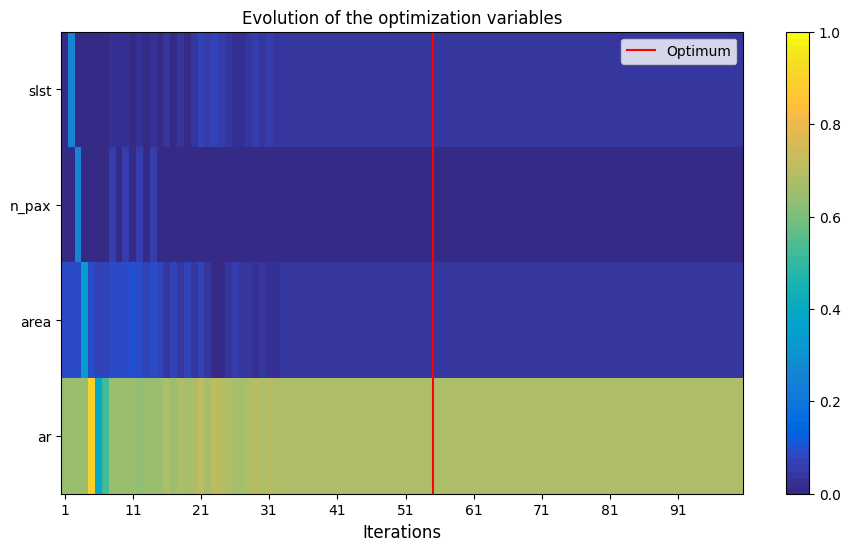

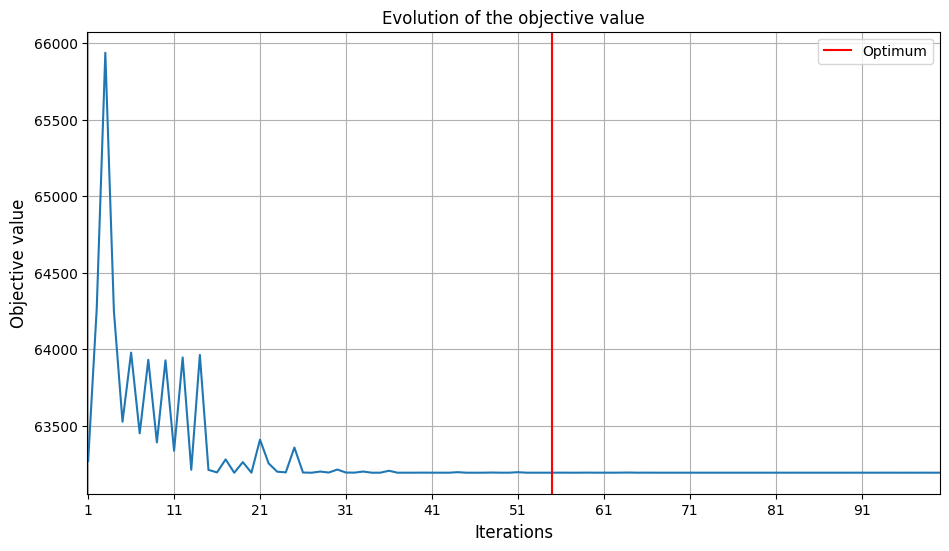

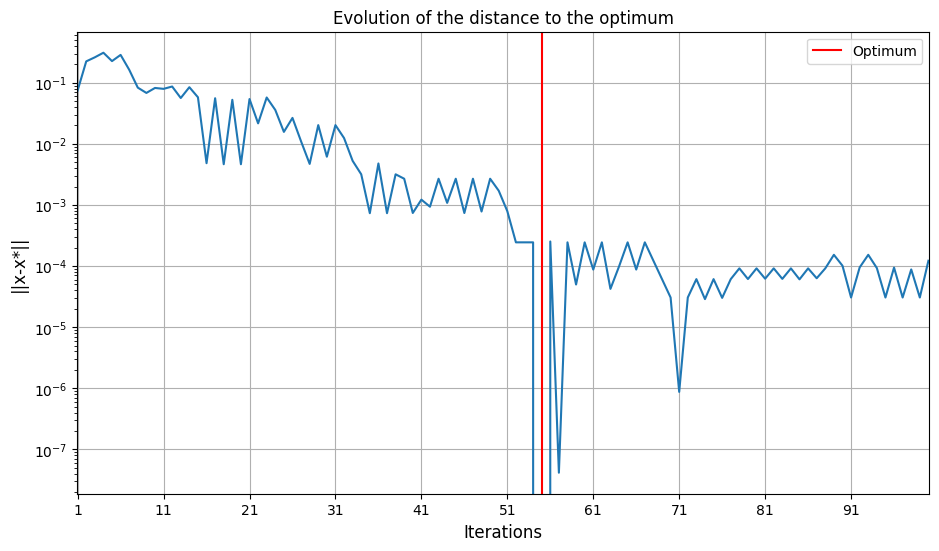

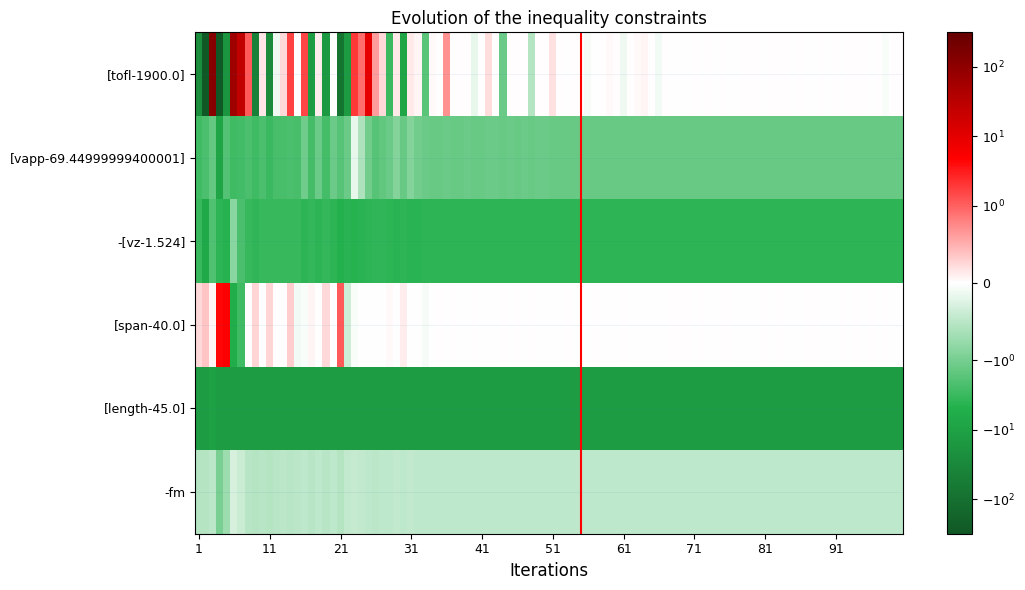

In [21]:
scenario_surr.post_process(post_name="OptHistoryView", save=False, show=True)

### comparer

In [32]:
scenario.optimization_result

Optimization result:
   Design variables: [1.00000000e+05 1.20000000e+02 1.09204574e+02 1.46513983e+01]
   Objective function: 63138.08988269419
   Feasible solution: True

In [33]:
scenario_surr.optimization_result

Optimization result:
   Design variables: [1.03587826e+05 1.20000000e+02 1.03565305e+02 1.51591816e+01]
   Objective function: 63194.518103804185
   Feasible solution: True